In [1]:
%load_ext autoreload
%autoreload 2

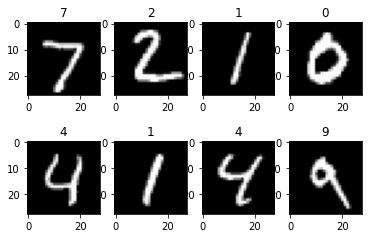

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from SGD_TC import SGD_TC
from ADAM_TC import ADAM_TC

# Load MNIST Datasets
train_ds = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST(root='/data', train=False, transform=transforms.ToTensor(), download=True)

# Dataloader constructor
def get_minibatcher(dataset, batchsize, shuffle):
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batchsize, shuffle=shuffle, pin_memory=True)
    # For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors 
    # in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

# Dataset examples
test_dl = get_minibatcher(test_ds, 10, False)
examples = iter(test_dl)
example_images, example_targets = examples.next()

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(example_images[i][0], cmap='gray')
    plt.title(int(example_targets[i]))
plt.show()

In [3]:
# Define fully connected neural network with 1/2 hidden layers
# Input size = 784 (28 x 28 pixel images)
# Output size = 10 (digits 1-10)
# Expedite training by introducing heavy-tailed noise from the start, rather than waiting for it to emerge

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 200, bias=False)
        #self.fc1 = nn.Linear(28*28, 10, bias=False)
        #self.fc2 = nn.Linear(200, 50, bias=False)
        #self.fc3 = nn.Linear(50, 10, bias=False)
        self.fc3 = nn.Linear(200, 10, bias=False)
    
    def forward(self, X):
        X = torch.relu(self.fc1(X))
        #X = torch.relu(self.fc2(X))
        X = self.fc3(X)

        return X

class FullyConnected(nn.Module):

    def __init__(self, input_dim=28*28 , width=50, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim 
        self.width = width
        self.depth = depth
        self.num_classes = num_classes
        
        layers = self.get_layers()

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):
        layers = []
        for i in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        x = x.view(x.size(0), self.input_dim)
        x = self.fc(x)
        return x
    
    def get_grads(self):
        res = []
        for p in self.parameters():
            if p.requires_grad:
                res.append(p.grad.view(-1))
        grad_flat = torch.cat(res)
        return grad_flat

def cyclic_loader(dataloader):
    while True:
        for data in dataloader:
            yield data

# Based on Simsekli 2019    
def eval(dataloader, model, criterion, opt, device, alpha_est_sig_bound):
    
    model.eval()
    grads = []
    batch_count = 0

    for batch in dataloader:
        batch_count += 1
        opt.zero_grad()
        X, y = batch[0].to(device), batch[1].to(device)
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        grad = model.get_grads()
        grads.append(grad)
    
    param_num = len(grads[0])
    grads = torch.cat(grads).view(-1, param_num)                                            # column for each param, row for each batch
    full_batch_grad = grads.sum(dim=0) / batch_count                                        # sum across batches (down the rows)
    gradient_noise = grads - full_batch_grad
    noise_norm = gradient_noise.norm(dim=1)                                                 # compute norm of gradient vector for each batch(across columns)
    
    # Over parameterised --> many gradients stay 0, so we underestimate alpha --> clean these parameters.
    s = torch.sum(torch.abs(gradient_noise), dim=0)
    p = s/s.max()
    gradient_noise_cleaned = gradient_noise[:, p >= alpha_est_sig_bound]
    #print('Used {} number of params to estimate alpha'.format(sum(p >= alpha_est_sig_bound)))
    batch_count = gradient_noise_cleaned.shape[0]
    param_num = gradient_noise_cleaned.shape[1]

    N = param_num * batch_count
    for i in range(1 + int(np.sqrt(N)), 1, -1):
        if N % i == 0:
            m = i
            break
    
    alpha = alpha_estimator(m, gradient_noise_cleaned.view(-1, 1))
    
    del full_batch_grad
    del grads

    return gradient_noise.cpu(), noise_norm.cpu(), alpha

# Corollary 2.4 in Mohammadi 2014
def alpha_estimator(m, X):
    N = len(X)
    n = int(N/m)
    Y = torch.sum(X.view(n,m,-1,), 1)
    eps = np.spacing(1)
    Y_log_norm = torch.log(torch.linalg.norm(Y, dim=1) + eps).mean()
    X_log_norm = torch.log(torch.linalg.norm(X, dim=1) + eps).mean()
    #Y_log_norm = torch.log(Y.abs() + eps).mean()
    #X_log_norm = torch.log(X.abs() + eps).mean()
    diff = (Y_log_norm - X_log_norm) / np.log(m)
    return (1 / diff).item()

In [4]:
# Get fullbatch
# train_dl_fullbatch = get_minibatcher(train_ds, len(train_ds), False)
# for batch in train_dl_fullbatch:
#     print('Check full batch --- should only print once.')
#     full_batchX = batch[0].to(device)
#     full_batchy = batch[1].to(device)

# Define training procedure

def train_model(model, opt, device, criterion, alpha_est_sig_bound,
                train_cdl, train_dl_eval, train_loss, iteration_number, 
                eval_freq, gradient_noises, noise_norms, alphas):
    batch = next(train_cdl)
    model.train()
    opt.zero_grad()
    images = batch[0].to(device)
    label = batch[1].to(device)
    output = model(images)
    loss = criterion(output, label)
    loss.backward()
    opt.step()
    train_loss.append(loss.item())
    
    if not iteration_number % eval_freq:
        gradient_noise, noise_norm, alpha = eval(train_dl_eval, model, 
                                                criterion, opt, device, 
                                                alpha_est_sig_bound)
        gradient_noises.append(gradient_noise)
        noise_norms.append(noise_norm)
        alphas.append(alpha)

        # mini_batch_grads.append(model.get_grads())
        # # Wipe mini-batch gradients after SGD step, then compute full batch gradients
        # opt.zero_grad()
        # full_batch_output = model(full_batchX)
        # loss_full = criterion(full_batch_output.squeeze(-1), full_batchy)
        # loss_full.backward()
        # full_batch_grads.append(model.get_grads())

def model_train_analysis(model, opt, criterion, device, seed,
                         train_ds, batch_size, max_iterations, eval_freq, 
                         alpha_est_sig_bound, plot=False):
    torch.manual_seed(seed)
    train_dl = get_minibatcher(train_ds, batch_size, True)
    train_cdl = cyclic_loader(train_dl)
    train_dl_eval = get_minibatcher(train_ds, batch_size, False)

    # LR-Scheduler
    milestone = int(max_iterations/3)
    scheduler = optim.lr_scheduler.MultiStepLR(opt, 
                                            milestones=[milestone, 2*milestone],
                                            gamma=0.01
                )

    # Training
    gradient_noises = []
    noise_norms = []
    alphas = []
    train_loss = []

    if plot:
        for i in tqdm(range(max_iterations)):
            train_model(model, opt, device, criterion, alpha_est_sig_bound,
                        train_cdl, train_dl_eval, train_loss, i, 
                        eval_freq, gradient_noises, noise_norms, alphas)

    else:
        for i in range(max_iterations):
            train_model(model, device, criterion, alpha_est_sig_bound,
                        train_cdl, train_dl_eval, opt, train_loss, i, 
                        eval_freq, gradient_noises, noise_norms, alphas)
                
            
    predlist = torch.zeros(0, dtype=torch.long).to(device)
    labellist = torch.zeros(0, dtype=torch.long).to(device)

    # Testing
    with torch.no_grad():
        for ims, labels in test_dl:
            ims = ims.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(ims).to(device)
            _, predicted = torch.max(outputs.data, 1)
            predlist = torch.cat([predlist, predicted.view(-1)])
            labellist = torch.cat([labellist, labels.view(-1)])

    # Model evaluation
    if plot:
        print(classification_report(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()), digits=3))
        fig = px.line(train_loss)
        fig.show()
    acc = accuracy_score(np.asarray(labellist.cpu()), np.asarray(predlist.cpu()))

    del labellist
    del predlist

    return noise_norms, alphas, train_loss, acc

In [7]:
# Define parameters
device = 'cuda'
lr = 0.1
bounds = 1e3
height = 1.0
width = bounds/20

batch_size = 10
max_iterations = 1000
eval_freq = 10000
alpha_est_sig_bound = 0.1
nn_list, alphas_list, train_loss_list, acc_list = [], [], [], []

# Specify problem
model = FullyConnected().to(device)
criterion = nn.CrossEntropyLoss()
opt_params={'lr': lr, 'height': height, 'width': width, 'n_epochs': max_iterations}
#opt = torch.optim.SGD(params=model.parameters(), lr=lr)
opt = SGD_TC(params=model.parameters(), **opt_params)

nns, alphas, train_loss, acc = model_train_analysis(model, opt, criterion, device, 69,
                                                    train_ds, batch_size, max_iterations, eval_freq,
                                                    alpha_est_sig_bound, plot=True)
# for seed in range(10):
#     gns, nns, alphas, train_loss, acc = model_train_analysis(42, train_ds, batch_size, max_iterations, eval_freq, alpha_est_sig_bound, plot=False)
#     gn_list.append(gns)
#     nn_list.append(nns)
#     alphas_list.append(alphas)
#     train_loss_list.append(train_loss)
#     acc_list.append(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (50) must match the size of tensor b (784) at non-singleton dimension 1

In [7]:
noise_norms = nns
noise_norms_flat = [norm for noise_norm in noise_norms for norm in list(noise_norm)]
burnin = 60000//batch_size
print(len(noise_norms_flat), burnin)
px.histogram(noise_norms_flat[burnin:])
# Multimodal (second peak close to 0) if we include "burn-in"

300000 6000


In [8]:
px.line(x=eval_freq*np.arange(0,len(alphas)), y=alphas)

In [30]:
# For each gradient_noises entry
    #  Check across all batches, remove noise vector components that are always 0
gradient_noise_eg = gradient_noises[5]
s = torch.sum(torch.abs(gradient_noise_eg), dim=0)
p = s/s.max()
gradient_noise_eg_cleaned = gradient_noise_eg[:, p > 0.2]
noise_norm = gradient_noise_eg_cleaned.norm(dim=1)
batch_count = gradient_noise_eg_cleaned.shape[0]
param_num = gradient_noise_eg_cleaned.shape[1]

N = param_num * batch_count
for i in range(1+int(np.sqrt(N)), 1, -1):
    if N % i == 0:
        m = i
        break
print(gradient_noise.shape)
# Over parameterised --> many gradients stay 0, so we underestimate alpha?
alpha = alpha_estimator(m, gradient_noise_eg_cleaned.view(-1, 1))
print(alpha)

torch.Size([6000, 42200])
torch.Size([3132000, 1])
1.4747107028961182


In [156]:
s = torch.sum(torch.abs(gradient_noise_eg), dim=0)
p = s/s.max()
sum(p > 0.2)

tensor(1167)

In [ ]:
"""Code bank and notes"""

        # param in model.parameters() --> weights shape (output x input e.g. 200 x 28*28) then biases shape (output)
        # Setting bias=False in nn.Linear(...) gives only weight
        # one weight/bias pair for each network layer
        # for some reason - weight gradients always 0??? ---> ANS: no inputs to first layer, so ofc

        # Diagnostic code
        # for param in model.parameters():
        #     print(param.grad)
        #     print(param.grad.shape)
        #     print(param.shape)
        # print('epoch donnneeeee')
        # break

#     if not i % 5:
#         mini_batch_grads.append(model.get_grads())
#         # Wipe mini-batch gradients after SGD step, then compute full batch gradients
#         opt.zero_grad()
#         full_batch_output = model(full_batchX)
#         loss_full = criterion(full_batch_output.squeeze(-1), full_batchy)
#         loss_full.backward()
#         full_batch_grads.append(model.get_grads())

        # # Compute gradient noise
        # print(len(mini_batch_grads))
        # grad_noise_mags = []
        # for mb_grad, fb_grad in zip(mini_batch_grads, full_batch_grads):
        # grad_noise = mb_grad - fb_grad
        # grad_noise_mag = torch.linalg.norm(grad_noise.cpu())
        # grad_noise_mags.append(grad_noise_mag)
        # px.histogram(grad_noise_mags)

In [10]:
from scipy.stats import levy_stable
levy_r = levy_stable.rvs(1.9, 0, scale=1, size=1000)
sds = np.std(levy_r)
levy_r = levy_r[(levy_r-np.mean(levy_r))/sds < 3]
px.histogram(levy_r)